# Stage 2: ETL Pipeline & Machine Learning

**Description:**
This notebook implements the "Silver" and "Gold" layers of the Data Lakehouse.
It performs data cleaning, feature engineering, and unsupervised machine learning (Clustering) to segment products based on their chemical composition.

**Tech Stack:**
* **ETL:** Pandas (Cleaning, Imputation)
* **ML:** Scikit-learn (StandardScaler, K-Means)
* **Storage:** Parquet

Loading raw data from: ../data/raw/supplements_raw.parquet
Initial row count: 2000
Starting Data Cleaning...
   - Removed 3 rows with invalid pricing.
   - Imputing missing Magnesium values using category medians...
Transformation completed.
Running K-Means Clustering...
Segments assigned: ['Budget Essentials', 'Balanced / Standard', 'High-Potency Premium']
Generating Cluster Visualization...


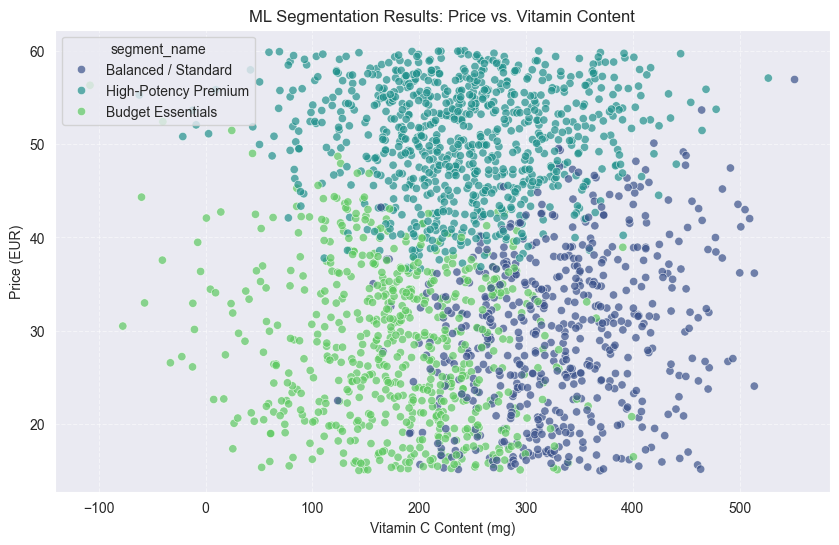

Enriched data saved to: ../data/processed/supplements_enriched.parquet


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Constants ---
INPUT_FILE = '../data/raw/supplements_raw.parquet'
OUTPUT_DIR = '../data/processed'
OUTPUT_FILE = 'supplements_enriched.parquet'

# --- 1. Extraction (Load from Bronze Layer) ---
print(f"Loading raw data from: {INPUT_FILE}")
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"File not found: {INPUT_FILE}. Please run Notebook 01 first.")

df = pd.read_parquet(INPUT_FILE)
print(f"Initial row count: {len(df)}")

# --- 2. Transformation (Data Cleaning) ---
print("Starting Data Cleaning...")

# Step A: Handling Technical Errors
# Filter out invalid prices (Business Rule: Price must be > 0)
initial_count = len(df)
df_clean = df[df['price_eur'] > 0].copy()
dropped_rows = initial_count - len(df_clean)
print(f"   - Removed {dropped_rows} rows with invalid pricing.")

# Step B: Imputation (Handling Missing Data)
# Strategy: Fill missing Magnesium with the Median value of its Category
# This is more accurate than filling with 0 or the global mean.
print("   - Imputing missing Magnesium values using category medians...")
df_clean['magnesium_mg'] = df_clean['magnesium_mg'].fillna(
    df_clean.groupby('category')['magnesium_mg'].transform('median')
)

# Step C: Feature Engineering (Creating Business Metrics)
# Calculating 'Potency Score' (Total active ingredients)
df_clean['total_active_mg'] = df_clean['vitamin_c_mg'] + df_clean['magnesium_mg']

# Calculating 'Value for Money' (Price per 1000mg of active ingredients)
# A lower value means better value for the customer.
df_clean['price_per_1000mg'] = (df_clean['price_eur'] / df_clean['total_active_mg']) * 1000

print("Transformation completed.")

# --- 3. Machine Learning (Product Segmentation) ---
print("Running K-Means Clustering...")

# Feature Selection for Clustering
features = ['price_eur', 'vitamin_c_mg', 'magnesium_mg']

# Standardization (Crucial for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

# Applying K-Means (k=3)
# We assume 3 market segments: Budget, Standard, Premium/High-Dose
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['cluster_id'] = kmeans.fit_predict(X_scaled)

# Analyzing Clusters to assign readable labels
# We calculate the mean price for each cluster to identify them dynamically
cluster_means = df_clean.groupby('cluster_id')['price_eur'].mean().sort_values()

# Mapping logic: Lowest price -> Budget, Middle -> Standard, Highest -> Premium
# Creating a dictionary {cluster_id: 'Label'}
cluster_map = {
    cluster_means.index[0]: 'Budget Essentials',
    cluster_means.index[1]: 'Balanced / Standard',
    cluster_means.index[2]: 'High-Potency Premium'
}

df_clean['segment_name'] = df_clean['cluster_id'].map(cluster_map)
print(f"Segments assigned: {list(cluster_map.values())}")

# --- 4. Visualization (Sanity Check) ---
print("Generating Cluster Visualization...")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x='vitamin_c_mg',
    y='price_eur',
    hue='segment_name',
    palette='viridis',
    alpha=0.7
)
plt.title('ML Segmentation Results: Price vs. Vitamin Content')
plt.xlabel('Vitamin C Content (mg)')
plt.ylabel('Price (EUR)')
plt.grid(True, linestyle='--', alpha=0.5)
# Saving plot for documentation/presentation
plt.savefig('cluster_analysis.png')
plt.show()

# --- 5. Load (Save to Gold Layer) ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
full_output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)

df_clean.to_parquet(full_output_path, engine='pyarrow')
print(f"Enriched data saved to: {full_output_path}")